In [1]:
import geopandas as gpd
import pandas as pd 
from sklearn import preprocessing 
from tqdm import tqdm
import networkx as nx
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import evaluation
import math
import random
import community
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from modularity_maximization import partition
from modularity_maximization.utils import get_modularity
from modutils import mod_calc
device = torch.device('cpu')
from typing import Dict
from scipy.sparse import coo_matrix

## graph construction

In [2]:
sample_num = 2000

In [3]:
# 确认节点数量
bs_gpd = gpd.read_file('../../data/basestation-gis/basestation_aggregation.shp')
bs_gpd = bs_gpd.iloc[:sample_num:, ::]
bs_num = bs_gpd.shape[0]

# 构造图节点
nodes_list = list(range(bs_num))
G = nx.Graph()
G.add_nodes_from(nodes_list)

# 读取邻接矩阵adjacent
# 以工作日(周一)的早高峰时段为例
adj = pd.read_csv('../../data/adj/adj_20151109_0002.csv')
adj = adj.iloc[:, 1:].values
adj = adj[:sample_num:, :sample_num:]
adj = adj + adj.T
for i in range(sample_num): adj[i, i] = 0
    
for i in range(bs_num):
    if (adj[i]==0).all():
        adj[i, :] = 0.00001
        adj[:, i] = 0.00001

# D_12 = np.diag(np.power(np.sum(adj, axis=0)+0.00001, -1/2))
# adj_norm = np.dot(np.dot(D_12, adj), D_12)

for i in tqdm(range(bs_num)):
    for j in range(bs_num):
        tmp = adj[i, j]
        if tmp>0: G.add_edge(i, j, weight=tmp)

100%|██████████| 2000/2000 [00:03<00:00, 581.73it/s]


## Feature Construction

In [4]:
feature = pd.read_csv('../../data/features/features_wf_new.csv')
feature = feature.iloc[:, 1::].values

In [5]:
feature = feature[:sample_num:, :]

## prior information

In [4]:
partition = community.best_partition(G)
partition_count = {}
for key, value in partition.items():
    if value not in partition_count:
        partition_count[value] = 1
    else:
        partition_count[value] = partition_count[value] + 1

In [5]:
print(community.modularity(partition, G, weight='weight'))
clusters_number = 0
for key, value in partition_count.items():
    if value > 1:
        clusters_number = clusters_number + 1
print(clusters_number)

clusters_number = 15
remapping = {}
idx = 0
for key, value in partition_count.items():
    if value>1 and key not in remapping:
        remapping[key] = idx
        idx = idx + 1

alpha = 2
W_prior = np.zeros((bs_num, clusters_number))
for key, value in partition.items():
    try:
        W_prior[key, remapping[value]] = alpha
    except:
        pass

0.6040005418528384
11


## partition process

np.identity()只能创建方阵，np.eye()可以创建一般矩阵，主对角线为1，其余元素为0。

In [6]:
# clusters_number = 15
A_hat = torch.tensor(nx.adjacency_matrix(G).todense(), dtype=np.float) # a matrix: A
X = np.identity(G.number_of_nodes(), dtype=np.float)

class CDRAE(nn.Module):
    def __init__(self, A_hat, num_feat, num_hidden):
        super(CDRAE, self).__init__()
        f = nn.Softmax(dim=1)
        self.num_feat = num_feat # 特征数 f
        self.num_hidden = num_hidden # 隐含数 h
        self.A_hat = A_hat
        self.d = torch.tensor(list(dict(G.degree()).values()), dtype=np.float).contiguous().view(-1, 1)
        self.ddT = torch.mm(self.d, self.d.T)
        self.B = (self.A_hat - torch.div(self.ddT, torch.norm(self.A_hat, p=1))).float()
        self.B_norm = torch.div(self.B, torch.norm(self.A_hat, p=1))
        self.W_0 = nn.Parameter(f(torch.ones(num_feat, num_hidden)+W_prior)) # [1][f*h]
#         # random.sample(range(0, num_feat), num_feat)可用实现不放回抽样，用于随机排序。
#         random_feat = random.sample(range(0, num_feat), num_feat)
#         # 将每个sample出的数值编码为一个onehot，作为I的一行。
#         I = F.one_hot(torch.tensor(random_feat), num_classes=num_feat)
#         self.I = torch.tensor(I, dtype=torch.float)

    def forward(self, X, A_hat,temp, epoch): # X貌似暂时没有用到
        global featureSelector # 
        global weight_feature # 
        featureSelector = self.W_0 # [1][f*h]
        results = torch.zeros(self.W_0.size()) # [0][f*h]
        x = 2*(epoch+1) # x次取平均,目测这个目的是为了稳定。
        for i in range(x):
            # logits --> self.W_0: [batch_size, num_features] 非规范化对数概率
            # tau: 非负的对抗强度。
            # hard: 如果 True, 返回的样本将会离散为 one-hot 向量
            results += F.gumbel_softmax(self.W_0,tau=temp,hard=False)
        weight_feature = results/x # [-][f*h]

        # H = torch.mm(torch.mm(weight_feature.T, B), weight_feature) # weight_feature 就是我们要求的U
        H = torch.mm(torch.mm(weight_feature.T, self.B_norm), weight_feature) # weight_feature 就是我们要求的U
        Hh = torch.div(H, H.sum(axis=0)) # 按照每一列进行归一化，列为axis=0的方向。
        m = nn.Softmax(dim=0)
        return m(Hh)
    
def lossFn(output): 
    return torch.trace(-torch.log(output))

In [62]:
num_feat = len(G.nodes()) # f = 节点数
num_hidden = clusters_number # h = 聚类数

model = CDRAE(A_hat, num_feat, num_hidden).to(device)

optimizer = optim.Adam(model.parameters(),lr=1.5e-2)
# optimizer = optim.Adam(model.parameters(),lr=1e-2,weight_decay=0,betas=(0.5, 0.999), eps=1e-08)

A_hat_tensor = torch.Tensor(A_hat.float()).to(device)
X_tensor = torch.Tensor(X).to(device)

loss_hist = []
modularity_hist = []
# acc_hist = []
temp = 3

for epoch in range(300):
    model.train()
    model.zero_grad()
    if(epoch == 75):
        temp = 2.75
    elif(epoch == 100):
        temp = 2.5
    elif(epoch == 125):
        temp = 2
    elif(epoch == 150):
        temp = 1.8
    elif(epoch == 175):
        temp = 1.25
    elif(epoch == 250):
        temp = 1.00
    elif(epoch == 300):
        temp = 0.75
    elif(epoch == 320):
        temp = 0.50
    elif(epoch == 400):
        temp = 0.20
    output = model(X_tensor, A_hat_tensor, temp, epoch)
    ############################################
    loss = lossFn(output)
    loss_hist.append(loss.item())
    ############################################
    gumbel_matrix = weight_feature.detach().max(dim=1)[1] # 每个节点的标签组成的tensor
    labels_pred = gumbel_matrix.data.numpy()
    modularity = community.modularity(dict(zip(list(range(len(labels_pred))), labels_pred)), G, weight='weight')
    modularity_hist.append(modularity)
    
    if epoch%10==0: 
        print('Epoch: ', epoch, '; Loss: ', round(loss.item(), 4), '; Modulariy: ', round(modularity, 4))
    loss.backward()
    optimizer.step()

Epoch:  0 ; Loss:  40.6196 ; Modulariy:  -0.0017
Epoch:  10 ; Loss:  40.6172 ; Modulariy:  0.1852
Epoch:  20 ; Loss:  40.6148 ; Modulariy:  0.5057
Epoch:  30 ; Loss:  40.6107 ; Modulariy:  0.5928
Epoch:  40 ; Loss:  40.603 ; Modulariy:  0.5992
Epoch:  50 ; Loss:  40.5901 ; Modulariy:  0.6033
Epoch:  60 ; Loss:  40.5706 ; Modulariy:  0.6035
Epoch:  70 ; Loss:  40.5389 ; Modulariy:  0.6032
Epoch:  80 ; Loss:  40.468 ; Modulariy:  0.6032
Epoch:  90 ; Loss:  40.3909 ; Modulariy:  0.6032
Epoch:  100 ; Loss:  40.2198 ; Modulariy:  0.6032
Epoch:  110 ; Loss:  40.0649 ; Modulariy:  0.6032
Epoch:  120 ; Loss:  39.8831 ; Modulariy:  0.6032
Epoch:  130 ; Loss:  39.1948 ; Modulariy:  0.6033
Epoch:  140 ; Loss:  38.8418 ; Modulariy:  0.6024
Epoch:  150 ; Loss:  38.128 ; Modulariy:  0.6022
Epoch:  160 ; Loss:  37.6843 ; Modulariy:  0.598
Epoch:  170 ; Loss:  37.2224 ; Modulariy:  0.5871
Epoch:  180 ; Loss:  35.6605 ; Modulariy:  0.5782
Epoch:  190 ; Loss:  35.1772 ; Modulariy:  0.5565
Epoch:  200 ; 

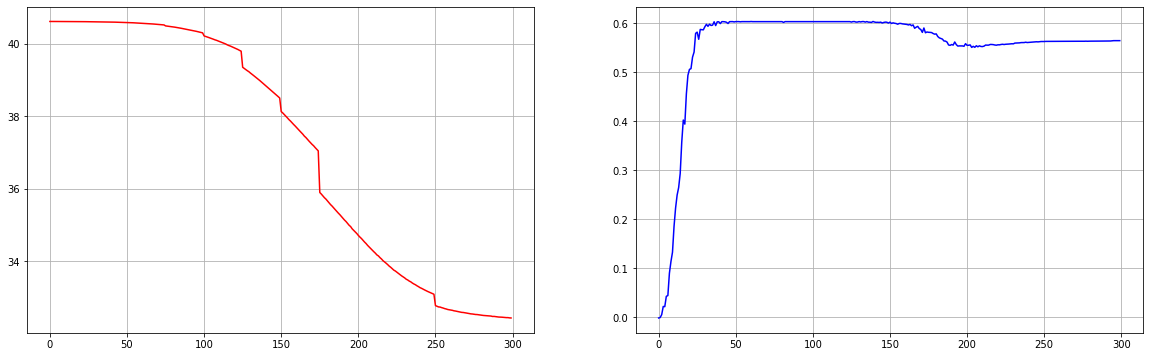

torch.Size([2000, 15])


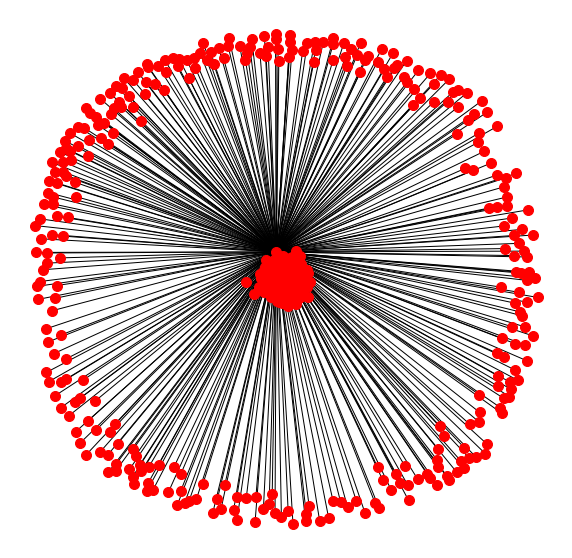

0.6035798857671296


In [63]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_hist, color='red')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(modularity_hist, color='blue')
plt.grid(True)
plt.show()

print(weight_feature.detach().size())
gumbel_matrix = weight_feature.detach().max(dim=1)[1] # 每个节点的标签组成的tensor
labels_pred = gumbel_matrix.data.numpy()
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 10))
plt.axis('off')
nx.draw_networkx(G, pos=pos, node_size=100, node_color="r", with_labels=False)
options = {
    'node_color': 'red',
    'node_size': 10,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.1,
}
plt.show()

print(max(modularity_hist))

**prior + variable_sample_num**

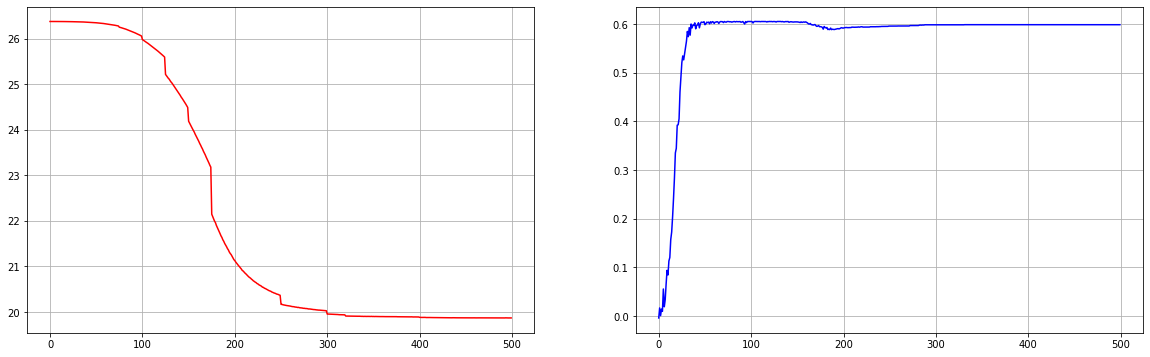

torch.Size([2000, 11])


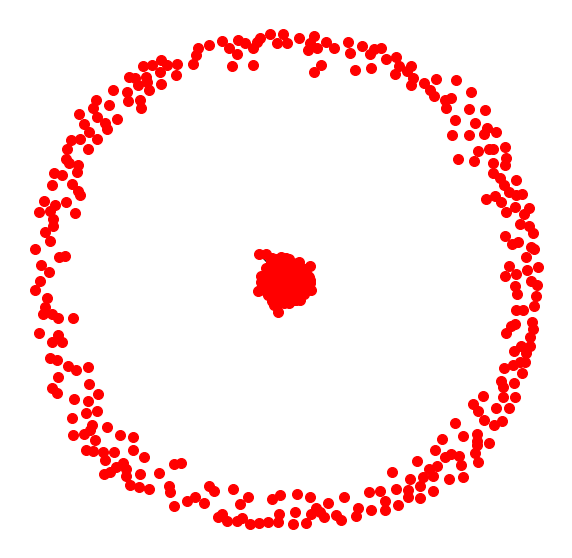

0.605734372581189


In [144]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_hist, color='red')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(modularity_hist, color='blue')
plt.grid(True)
plt.show()

print(weight_feature.detach().size())
gumbel_matrix = weight_feature.detach().max(dim=1)[1] # 每个节点的标签组成的tensor
labels_pred = gumbel_matrix.data.numpy()
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 10))
plt.axis('off')
nx.draw_networkx(G, pos=pos, node_size=100, node_color="r", with_labels=False)
options = {
    'node_color': 'red',
    'node_size': 10,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.1,
}
plt.show()

print(max(modularity_hist))

**no prior**

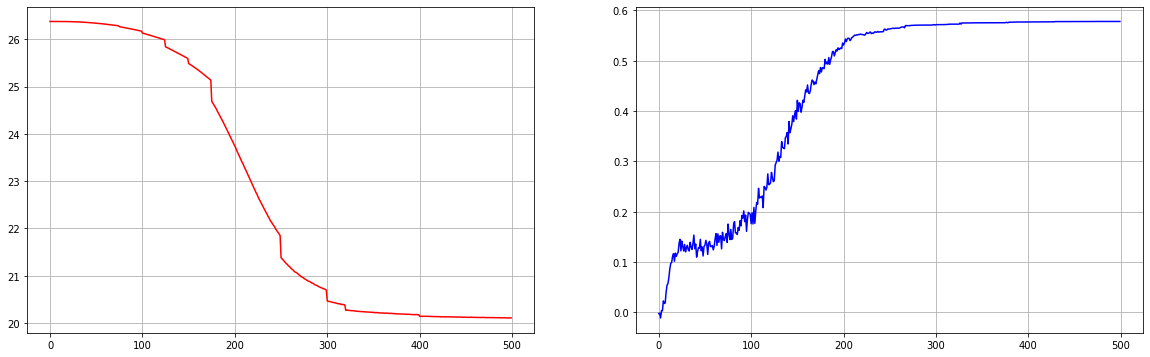

torch.Size([2000, 11])


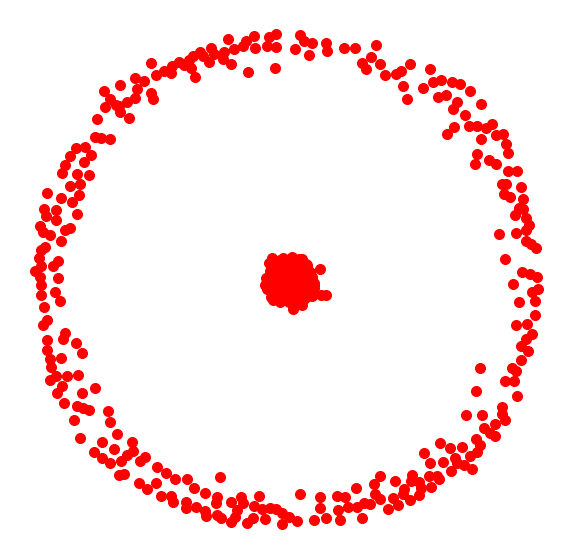

Modularity_false is 0.66946
Modularity_true is 0.57789


In [50]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_hist, color='red')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(modularity_hist, color='blue')
plt.grid(True)
plt.show()

print(weight_feature.detach().size())
gumbel_matrix = weight_feature.detach().max(dim=1)[1] # 每个节点的标签组成的tensor
labels_pred = gumbel_matrix.data.numpy()
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 10))
plt.axis('off')
nx.draw_networkx(G, pos=pos, node_size=100, node_color="r", with_labels=False)
options = {
    'node_color': 'red',
    'node_size': 10,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.1,
}
plt.show()

print('Modularity_false is %.5f' %evaluation.modularity(G, labels_pred))
print('Modularity_true is %.5f' %community.modularity(dict(zip(list(range(len(labels_pred))), labels_pred)), G, weight='weight'))